# Read Results

In [14]:
#We use pickle to store intermediate results, ensuring reproducibility and 
# allowing future experiments to skip data preparation and unimodal encoder processing.
import pickle

with open("cache/dpf_mvsa_single_results.pkl", "rb") as f:
    results = pickle.load(f)

# RETRIEVE  Varibles from results
train_probs_text   = results["train_probs_text"]
train_probs_image  = results["train_probs_image"]

val_probs_text     = results["val_probs_text"]
val_probs_image    = results["val_probs_image"]

test_probs_text    = results["test_probs_text"]
test_probs_image   = results["test_probs_image"]

y_train_int = results["y_train_int"]
y_val_int   = results["y_val_int"]
y_test_int  = results["y_test_int"]

beta  = results["beta"]
topk  = results["topk"]
delta = results["delta"]

Per-sample modality weights produced by DPF on the MVSA test set. 
Each point represents one instance, with x- and y-coordinates denoting the assigned weights to the text and image modalities, respectively. 
All points lie exactly on the line $w_{\text{text}} + w_{\text{image}} = 1$, confirming correct normalization. 
The wide spread of points (ranging from near (0,1) to (1,0)) demonstrates strong per-instance adaptivity: 
DPF automatically assigns higher weight to the modality with lower uncertainty (higher confidence) for that specific sample.

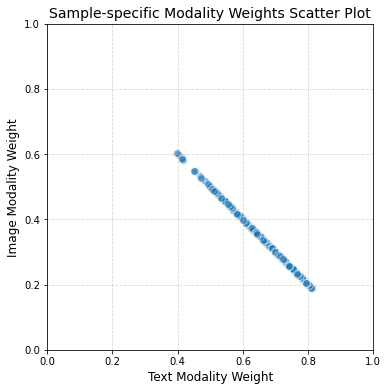

In [3]:
import matplotlib.pyplot as plt

def plot_modality_weights_scatter(weights):
    plt.figure(figsize=(8, 6))
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=60)
    plt.title("Sample-specific Modality Weights Scatter Plot", fontsize=14)
    plt.xlabel("Text Modality Weight", fontsize=12)
    plt.ylabel("Image Modality Weight", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# plot_modality_weights_scatter(weights)

wx = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
plot_modality_weights_scatter(wx)

# Effect of β on Fusion Weights (DPF)
DPF’s adaptive fusion is fully controllable with just one parameter. As β increases, the system smoothly transitions from “treat every modality equally” to “trust only the most reliable modality”. Everything is deterministic, interpretable, and predictable — no black-box behavior.

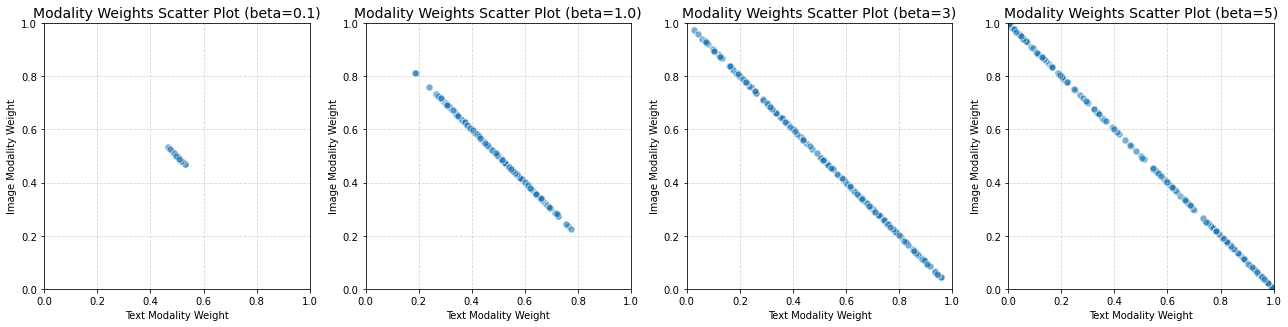

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_weights(beta, n_samples=200):
    # (n_samples, n_classes=5)
    probs_text = np.random.dirichlet(np.ones(5), size=n_samples)
    probs_image = np.random.dirichlet(np.ones(5), size=n_samples)

    # Top-k = 2
    topk = 2
    delta = 1e-4

    # Top-k ranking
    topk_prob_text = np.sort(probs_text, axis=1)[:, -topk:]
    topk_prob_image = np.sort(probs_image, axis=1)[:, -topk:]

    # adaptive epsilon
    adaptive_eps_text = delta * np.max(topk_prob_text**2, axis=1, keepdims=True)
    adaptive_eps_image = delta * np.max(topk_prob_image**2, axis=1, keepdims=True)

    # energy計算
    energy_text = -np.log(np.sum(topk_prob_text**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob_image**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Gibbs softmax
    energies = np.vstack([energy_text, energy_image]).T
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

# Plot Scatter
def plot_weights_scatter(weights, beta):
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=50)
    plt.title(f"Modality Weights Scatter Plot (beta={beta})", fontsize=14)
    plt.xlabel("Text Modality Weight")
    plt.ylabel("Image Modality Weight")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

betas = [0.1, 1.0, 3, 5]
plt.figure(figsize=(18, 5))
for i, beta in enumerate(betas):
    plt.subplot(1, 4, i+1)
    w = simulate_weights(beta)
    plot_weights_scatter(w, beta)
plt.tight_layout()
plt.show()


#  Rényi-2 entropy (measure of uncertainty) and Onicescu information energy (measure of certainty)
This visualization illustrates the inverse relationship between Rényi-2 entropy (measure of uncertainty) and Onicescu information energy (measure of certainty). This duality underpins our dynamic data processing framework: we monitor information energy during feature extraction to detect distribution characteristics and adapt our normalization and fusion strategies accordingly, moving beyond static one-size-fits-all processing.

C:\Users\ausco\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ausco\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


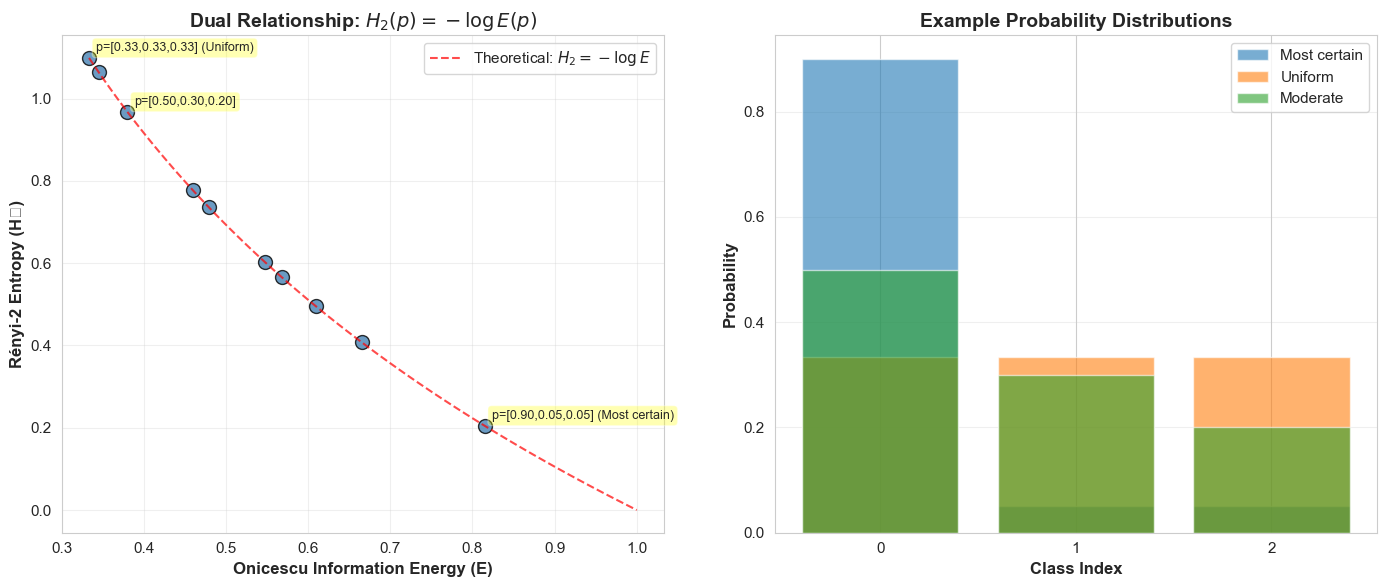

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# setting
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'figure.figsize': (10, 6)
})

# ========== 1. Generate 10 representative probability distributions ==========
np.random.seed(42)  # For reproducibility

# Create 10 different probability vectors (dimension C=3)
C = 3  # Number of classes
distributions = []

# 1. Very certain distribution (low entropy, high energy)
distributions.append(np.array([0.9, 0.05, 0.05]))

# 2. Certain distribution
distributions.append(np.array([0.8, 0.15, 0.05]))

# 3. Moderately certain distribution
distributions.append(np.array([0.6, 0.3, 0.1]))

# 4. Uniform but slightly biased distribution
distributions.append(np.array([0.5, 0.3, 0.2]))

# 5. Nearly uniform distribution
distributions.append(np.array([0.4, 0.35, 0.25]))

# 6. Completely uniform distribution (highest entropy, lowest energy)
distributions.append(np.array([0.33333, 0.33333, 0.33334]))

# 7-10: Some random but reasonable distributions
for _ in range(4):
    # Generate random numbers and normalize
    random_probs = np.random.dirichlet([1, 1, 1])
    distributions.append(random_probs)

# ========== 2. Calculate E and H2 ==========
def onicescu_energy(p):
    """Onicescu Information Energy: E(p) = Σ p_i²"""
    return np.sum(p**2)

def renyi2_entropy(p):
    """Rényi-2 Entropy: H₂(p) = -log(Σ p_i²)"""
    return -np.log(onicescu_energy(p))

E_values = []
H2_values = []
labels = []

for i, p in enumerate(distributions):
    E = onicescu_energy(p)
    H2 = renyi2_entropy(p)
    E_values.append(E)
    H2_values.append(H2)
    
    # Create distribution labels
    if i == 0:
        labels.append(f"p=[{p[0]:.2f},{p[1]:.2f},{p[2]:.2f}] (Most certain)")
    elif i == 5:
        labels.append(f"p=[{p[0]:.2f},{p[1]:.2f},{p[2]:.2f}] (Uniform)")
    else:
        labels.append(f"p=[{p[0]:.2f},{p[1]:.2f},{p[2]:.2f}]")

# ========== 3. Plot main relationship graphs ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Figure 1: E vs H2 scatter plot
ax1.scatter(E_values, H2_values, color='steelblue', s=100, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Onicescu Information Energy (E)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Rényi-2 Entropy (H₂)', fontsize=12, fontweight='bold')
ax1.set_title('Dual Relationship: $H_2(p) = -\log E(p)$', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add theoretical curve (continuous relationship)
E_continuous = np.linspace(1/C, 1, 100)  # Theoretical range of E: [1/C, 1]
H2_continuous = -np.log(E_continuous)
ax1.plot(E_continuous, H2_continuous, 'r--', alpha=0.7, linewidth=1.5, label='Theoretical: $H_2 = -\log E$')
ax1.legend()

# Mark several key points
highlight_indices = [0, 5, 3]  # Most certain, uniform, moderate
for idx in highlight_indices:
    ax1.annotate(labels[idx], 
                xy=(E_values[idx], H2_values[idx]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

# Figure 2: Probability distribution visualization (bar chart)
ax2.bar(range(len(distributions[0])), distributions[0], alpha=0.6, label='Most certain')
ax2.bar(range(len(distributions[5])), distributions[5], alpha=0.6, label='Uniform')
ax2.bar(range(len(distributions[3])), distributions[3], alpha=0.6, label='Moderate')
ax2.set_xlabel('Class Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax2.set_title('Example Probability Distributions', fontsize=14, fontweight='bold')
ax2.set_xticks(range(C))
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



Index  Probability Distribution       E(p)         H₂(p)        Description         
----------------------------------------------------------------------
1      [0.900, 0.050, 0.050]          0.815000     0.204567     Very certain        
2      [0.800, 0.150, 0.050]          0.665000     0.407968     Certain             
3      [0.600, 0.300, 0.100]          0.460000     0.776529     Moderate certainty  
4      [0.500, 0.300, 0.200]          0.380000     0.967584     Slightly biased     
5      [0.400, 0.350, 0.250]          0.345000     1.064211     Near uniform        
6      [0.333, 0.333, 0.333]          0.333333     1.098612     Uniform (max entropy)
7      [0.098, 0.628, 0.275]          0.478846     0.736375     Random 1            
8      [0.729, 0.135, 0.135]          0.568271     0.565157     Random 2            
9      [0.020, 0.673, 0.307]          0.547292     0.602773     Random 3            
10     [0.259, 0.004, 0.737]          0.609809     0.494609     Random 4      

C:\Users\ausco\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ausco\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


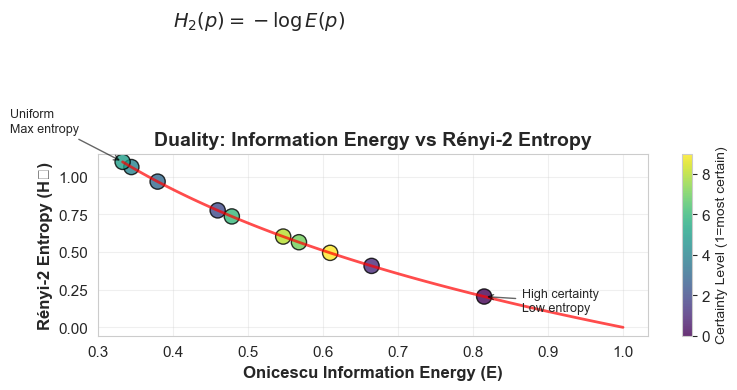

In [22]:
# ========== 4. Printing  ==========
print("=" * 70)
print(f"{'Index':<6} {'Probability Distribution':<30} {'E(p)':<12} {'H₂(p)':<12} {'Description':<20}")
print("-" * 70)

descriptions = [
    "Very certain", "Certain", "Moderate certainty", 
    "Slightly biased", "Near uniform", "Uniform (max entropy)",
    "Random 1", "Random 2", "Random 3", "Random 4"
]

for i, (p, E, H2) in enumerate(zip(distributions, E_values, H2_values)):
    prob_str = f"[{p[0]:.3f}, {p[1]:.3f}, {p[2]:.3f}]"
    print(f"{i+1:<6} {prob_str:<30} {E:.6f}     {H2:.6f}     {descriptions[i]:<20}")

print("=" * 70)
print("\nKey Observations:")
print("1. As probability concentrates on fewer classes, E(p) ↑ and H₂(p) ↓")
print("2. Uniform distribution (max entropy) has minimum E = 1/C = 0.333...")
print("3. Perfect certainty (one-hot) would give E = 1, H₂ = 0")
print("4. The dual relationship H₂ = -log(E) holds exactly")

# ========== 5. Plot logarithmic relationship verification graph ==========
fig2, ax3 = plt.subplots(1, 1, figsize=(8, 6))

# Plot scatter points
scatter = ax3.scatter(E_values, H2_values, c=range(len(E_values)), 
                     cmap='viridis', s=120, edgecolor='black', linewidth=1, alpha=0.8)

# Add color bar to represent certainty level
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Certainty Level (1=most certain)', fontsize=10)

# Add theoretical curve
ax3.plot(E_continuous, H2_continuous, 'r-', linewidth=2, alpha=0.7)

# Mark mathematical relationship
ax3.text(0.4, 2.0, r'$H_2(p) = -\log E(p)$', fontsize=14, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

ax3.set_xlabel('Onicescu Information Energy (E)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Rényi-2 Entropy (H₂)', fontsize=12, fontweight='bold')
ax3.set_title('Duality: Information Energy vs Rényi-2 Entropy', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add key point explanations
ax3.annotate('High certainty\nLow entropy', 
            xy=(E_values[0], H2_values[0]),
            xytext=(E_values[0]+0.05, H2_values[0]-0.1),
            arrowprops=dict(arrowstyle="->", color='black', alpha=0.6),
            fontsize=9)

ax3.annotate('Uniform\nMax entropy', 
            xy=(E_values[5], H2_values[5]),
            xytext=(E_values[5]-0.15, H2_values[5]+0.2),
            arrowprops=dict(arrowstyle="->", color='black', alpha=0.6),
            fontsize=9)

plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import entropy
H_text  = entropy(probs_text.T)
H_image = entropy(probs_image.T)
d = H_image - H_text

print("H_text  mean,std,min,max:", H_text.mean(),  H_text.std(),  H_text.min(),  H_text.max())
print("H_image mean,std,min,max:", H_image.mean(), H_image.std(), H_image.min(), H_image.max())
print("d=H_img-H_txt mean,std,min,max:", d.mean(), d.std(), d.min(), d.max())


H_text  mean,std,min,max: 0.8599397562952414 0.2809211845553466 0.0 1.096719839469558
H_image mean,std,min,max: 1.0601439296130561 0.03038603642940801 0.884856996220923 1.098541660403935
d=H_img-H_txt mean,std,min,max: 0.20020417331781476 0.27204190090444375 -0.14220530252933739 1.0898301667990082


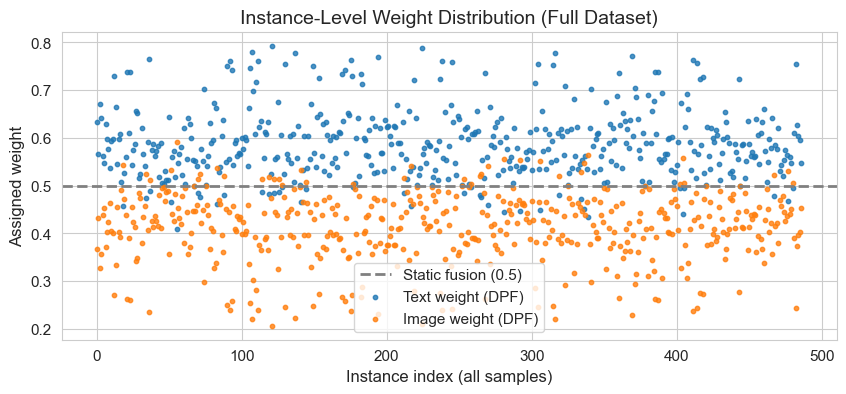

In [18]:
plt.figure(figsize=(10,4))
plt.scatter(np.arange(N), w_text, alpha=0.8, s=10, label='Text weight (DPF)')
plt.scatter(np.arange(N), w_image, alpha=0.8, s=10, label='Image weight (DPF)')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Static fusion (0.5)')
plt.xlabel('Instance index (all samples)')
plt.ylabel('Assigned weight')
plt.title('Instance-Level Weight Distribution (Full Dataset)')
plt.legend()
plt.show()

###  Showing Weights

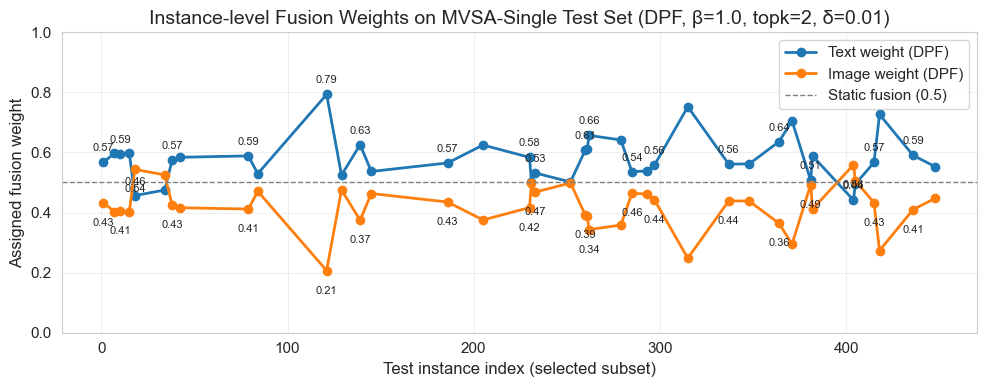

In [20]:
# ------------------------------------------------------------
# 4) Instance-level Fusion Weight Visualization (with annotations)
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))

plt.plot(sel, w_text[sel],  marker='o', linewidth=2, label='Text weight (DPF)')
plt.plot(sel, w_image[sel], marker='o', linewidth=2, label='Image weight (DPF)')
plt.axhline(0.5, color='gray', linestyle='--', linewidth=1,
            label='Static fusion (0.5)')

# ---- Annotate weights every other instance ----
for i, idx in enumerate(sel):
    if i % 2 == 0:  # every second point
        # Text weight annotation (slightly above)
        plt.text(
            idx, w_text[idx] + 0.03,
            f"{w_text[idx]:.2f}",
            fontsize=8,
            ha='center',
            va='bottom'
        )
        # Image weight annotation (slightly below)
        plt.text(
            idx, w_image[idx] - 0.05,
            f"{w_image[idx]:.2f}",
            fontsize=8,
            ha='center',
            va='top'
        )

plt.xlabel('Test instance index (selected subset)')
plt.ylabel('Assigned fusion weight')
plt.title(f'Instance-level Fusion Weights on MVSA-Single Test Set (DPF, β={beta}, topk={topk}, δ={delta})')
plt.ylim(0.0, 1.0)
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Instance-Level Reliability-Driven Fusion Behavior of DPF

This figure visualizes how DPF assigns fusion weights to text and image modalities on a per-instance basis, alongside their corresponding information-theoretic potential (ITP) scores. The aligned fluctuations show that modality influence changes systematically with predictive reliability, rather than remaining fixed as in static fusion. This visualization is used to make DPF’s decision logic transparent and traceable, allowing readers to directly observe how reliability signals drive fusion at the instance level.

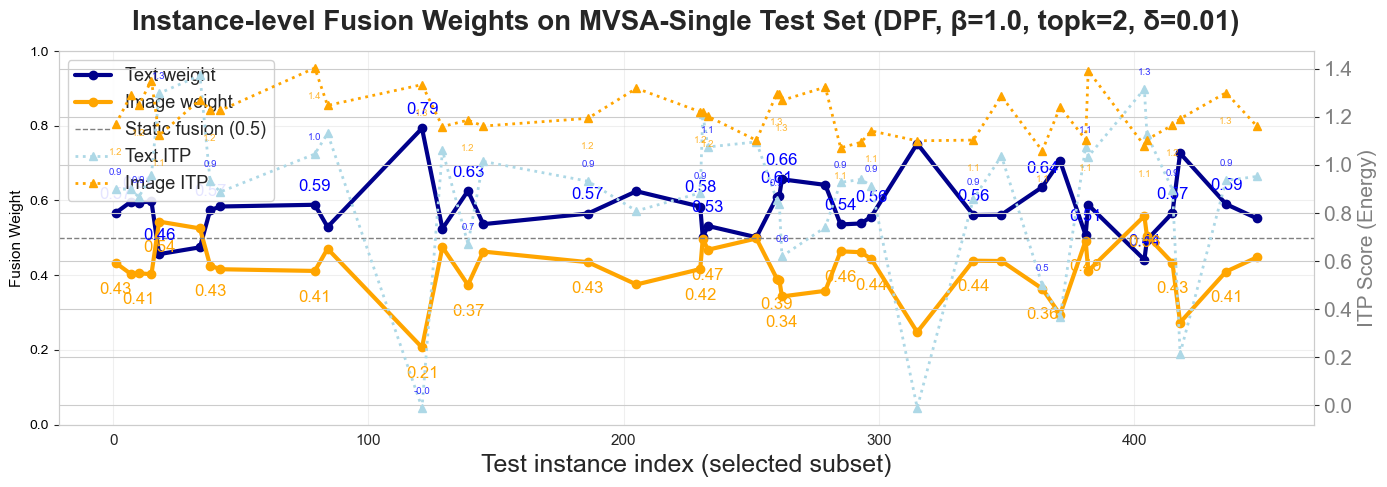

In [19]:
# ------------------------------------------------------------
# 4) Instance-level Fusion Weight & ITP Visualization (dual axis)
# ------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 5))

# Left Y-axis: Weights (primary)
ax1.plot(sel, w_text[sel],  marker='o', linewidth=3, label='Text weight', color='darkblue')
ax1.plot(sel, w_image[sel], marker='o', linewidth=3, label='Image weight', color='orange')
ax1.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='Static fusion (0.5)')
ax1.set_xlabel('Test instance index (selected subset)', fontsize=18)
ax1.set_ylabel('Fusion Weight', color='black', fontsize=11)
ax1.set_ylim(0.0, 1.0)
ax1.tick_params(axis='y', labelcolor='black', labelsize=10)
ax1.grid(alpha=0.3)

# Right Y-axis: ITP scores (secondary)
ax2 = ax1.twinx()
ax2.plot(sel, E_text[sel], marker='^', linestyle=':', linewidth=2, label='Text ITP', color='lightblue')
ax2.plot(sel, E_image[sel], marker='^', linestyle=':', linewidth=2, label='Image ITP', color='orange')
ax2.set_ylabel('ITP Score (Energy)', color='gray', fontsize=15)
ax2.tick_params(axis='y', labelcolor='gray', labelsize=15)

# ---- Dual annotation: Weight (top) + ITP (bottom) ----
for i, idx in enumerate(sel):
    if i % 2 == 0:  # annotate every other point
        # Weight annotations (blue/red)
        ax1.text(idx, w_text[idx] + 0.03, f"{w_text[idx]:.2f}", 
                 fontsize=12, ha='center', va='bottom', color='blue')
        ax1.text(idx, w_image[idx] - 0.05, f"{w_image[idx]:.2f}", 
                 fontsize=12, ha='center', va='top', color='orange')
        
        # ITP annotations (light colors)
        ax2.text(idx, E_text[idx] + 0.05, f"{E_text[idx]:.1f}", 
                 fontsize=7, ha='center', va='bottom', color='blue', alpha=0.8)
        ax2.text(idx, E_image[idx] - 0.1, f"{E_image[idx]:.1f}", 
                 fontsize=7, ha='center', va='top', color='orange', alpha=0.8)

# Merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=13, framealpha=0.9)

# Larger title

plt.title(f'Instance-level Fusion Weights on MVSA-Single Test Set (DPF, β={beta}, topk={topk}, δ={delta})', 
          fontsize=20, pad=15, weight='bold')
fig.tight_layout()
plt.show()